In [80]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from src.GP.data import *
from src.GP.plotting import *
from src.GP.GP import *

import scienceplots

plt.style.use('science')

In [81]:
import yaml

In [82]:
results_path = "/Users/jake/Python/Obs_and_exp_data/results/simulated_plot_exp/09-24-17:33:55/results.metrics"

In [83]:
with open(results_path, "r") as f:
    results_dict = yaml.safe_load(f) 

df = pd.DataFrame()
for model_name in results_dict:
    model_df = pd.DataFrame(results_dict[model_name])
    model_df["model"] = model_name
    df = pd.concat([df,model_df])
df.groupby(['model']).agg(['mean', 'std'])

COVERAGE_ID           COVERAGE_OD           Interval_width_ID  \
                    mean       std        mean       std              mean   
model                                                                        
fixed_MTGP      0.922161  0.109804    0.792042  0.233148          0.508948   
standard_GP     0.991107  0.033147    0.808746  0.234907          3.877725   
trained_MTGP    0.579357  0.379697    0.579043  0.363663          0.300671   

                       Interval_width_OD              MSE_ID            \
                   std              mean       std      mean       std   
model                                                                    
fixed_MTGP    0.068890          2.737991  0.573815  0.021211  0.013705   
standard_GP   0.295192          3.917817  0.016336  0.487032  0.415474   
trained_MTGP  0.189117          2.557834  1.534157  0.028465  0.024174   

                MSE_OD            
                  mean       std  
model                             
fixed_MTGP    1.651568  1.721634  
standard_GP   2.573203  2.712396  
trained_MTGP  2.352938  3.400822

In [84]:
fixed_MTGP_df = pd.DataFrame(results_dict["fixed_MTGP"])
trained_MTGP_df = pd.DataFrame(results_dict["trained_MTGP"])

In [85]:
fixed_MTGP_df.agg(['mean', 'std'])

,COVERAGE_ID,COVERAGE_OD,Interval_width_ID,Interval_width_OD,MSE_ID,MSE_OD
mean,0.922161,0.792042,0.508948,2.737991,0.021211,1.651568
std,0.109804,0.233148,0.068890,0.573815,0.013705,1.721634


In [86]:
trained_MTGP_df.agg(['mean', 'std'])

,COVERAGE_ID,COVERAGE_OD,Interval_width_ID,Interval_width_OD,MSE_ID,MSE_OD
mean,0.579357,0.579043,0.300671,2.557834,0.028465,2.352938
std,0.379697,0.363663,0.189117,1.534157,0.024174,3.400822


In [87]:
fixed_MTGP_df["model"] = "fixed_MTGP"
trained_MTGP_df["model"] = "trained_MTGP"

In [88]:
result_df = pd.concat([fixed_MTGP_df,trained_MTGP_df])

In [89]:
cfoundeded_func_plot = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfoundeded_func_plot = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

plot_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func_plot,
              uncfounded_func = uncfoundeded_func_plot)

cfoundeded_CATE_func = lambda X,T: cfoundeded_func_plot(X,1) - cfoundeded_func_plot(X,0)

T_prop = 0.6
n_samples_exp = 200
n_samples_obs = 1000

In [90]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP_1d(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,train_data = None)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X', ylabel='None'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X', ylabel='None'>],
       dtype=object))

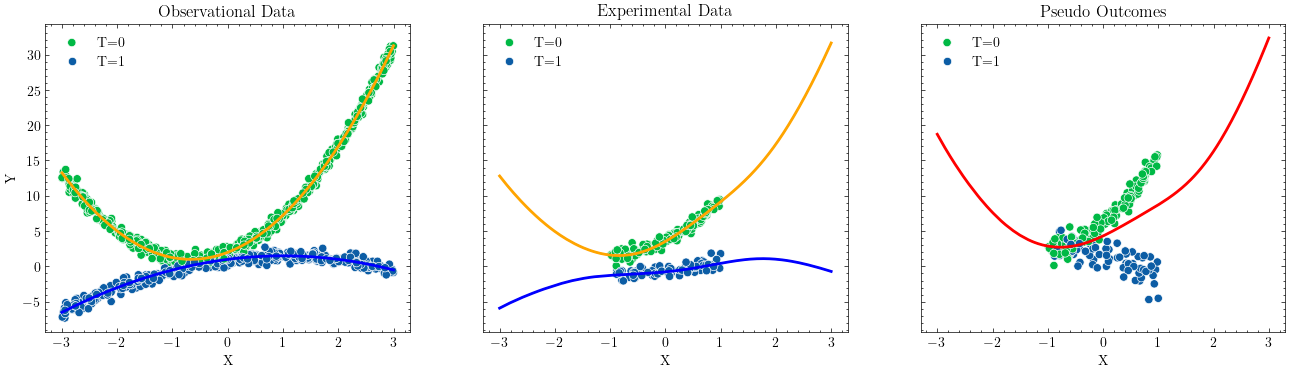

In [91]:
obs_exp_pseudo_plot(obs_data,exp_data,outcome_funcs_GP,T_prop=T_prop)

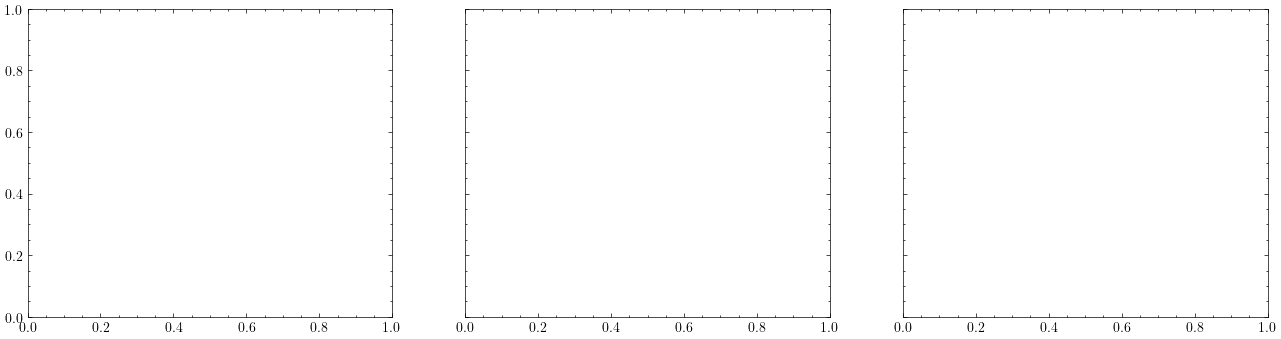

In [92]:
fig, axs= plt.subplots(ncols=3,sharex=True,figsize=(16,4),sharey=True)

In [93]:
pseudo_data = get_pseudo_outcome_data(exp_data,T_prop=T_prop)
pseudo_data_adjusted = adjust_data(pseudo_data,cfoundeded_CATE_func)

In [94]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = FixedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop,Train=False)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 1.760
Iter 2/50 - Loss: 1.725
Iter 3/50 - Loss: 1.697
Iter 4/50 - Loss: 1.675
Iter 5/50 - Loss: 1.657
Iter 6/50 - Loss: 1.644
Iter 7/50 - Loss: 1.635
Iter 8/50 - Loss: 1.628
Iter 9/50 - Loss: 1.623
Iter 10/50 - Loss: 1.619
Iter 11/50 - Loss: 1.616
Iter 12/50 - Loss: 1.615
Iter 13/50 - Loss: 1.613
Iter 14/50 - Loss: 1.612
Iter 15/50 - Loss: 1.611
Iter 16/50 - Loss: 1.611
Iter 17/50 - Loss: 1.610
Iter 18/50 - Loss: 1.609
Iter 19/50 - Loss: 1.609
Iter 20/50 - Loss: 1.608
Iter 21/50 - Loss: 1.607
Iter 22/50 - Loss: 1.606
Iter 23/50 - Loss: 1.605
Iter 24/50 - Loss: 1.603
Iter 25/50 - Loss: 1.602
Iter 26/50 - Loss: 1.601
Iter 27/50 - Loss: 1.600
Iter 28/50 - Loss: 1.600
Iter 29/50 - Loss: 1.599
Iter 30/50 - Loss: 1.599
Iter 31/50 - Loss: 1.598
Iter 32/50 - Loss: 1.598
Iter 33/50 - Loss: 1.598
Iter 34/50 - Loss: 1.598
Iter 35/50 - Loss: 1.598
Iter 36/50 - Loss: 1.599
Iter 37/50 - Loss: 1.599
Iter 38/50 - Loss: 1.599
Iter 39/50 - Loss: 1.599
Iter 40/50 - Loss: 1.599
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [95]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

In [96]:
FIGSIZE = (16,4)

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_9685/697062000.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


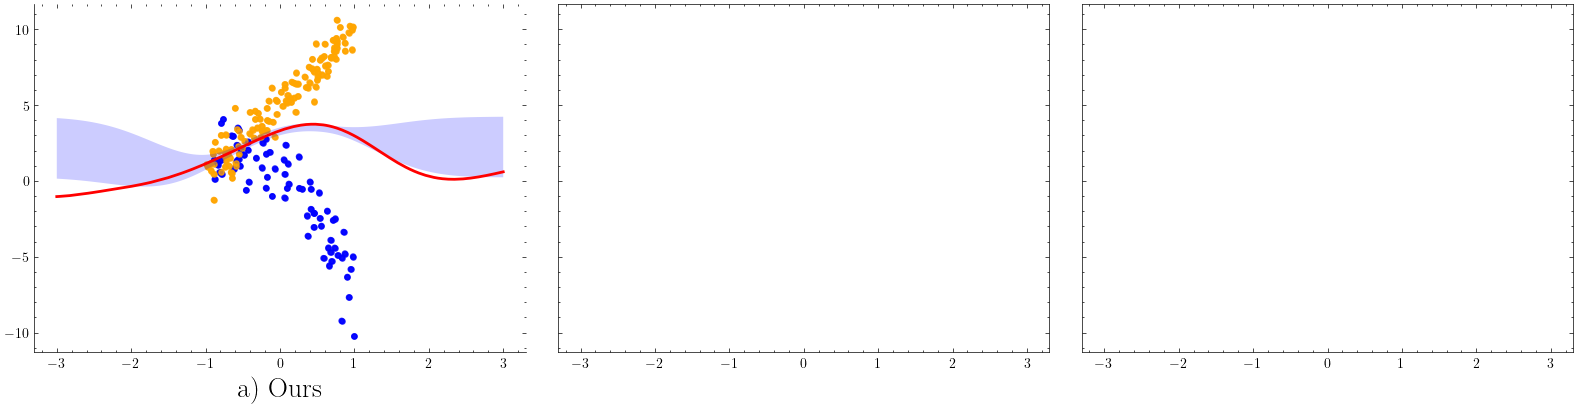

In [97]:
fig, axs = plt.subplots(ncols=3,sharex=True,figsize=FIGSIZE,sharey=True)
fig.tight_layout()
axs[0].set_axisbelow(True)
axs[0].set_title("a) Ours",y=-0.15,fontsize = 20)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
colors = ["blue","orange"]

scatter = axs[0].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[0].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)


axs[0].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95\% CI')

In [98]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_StandardGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 9.039
Iter 2/50 - Loss: 8.606
Iter 3/50 - Loss: 8.210
Iter 4/50 - Loss: 7.849
Iter 5/50 - Loss: 7.515
Iter 6/50 - Loss: 7.201
Iter 7/50 - Loss: 6.915
Iter 8/50 - Loss: 6.646
Iter 9/50 - Loss: 6.396
Iter 10/50 - Loss: 6.166
Iter 11/50 - Loss: 5.957
Iter 12/50 - Loss: 5.762
Iter 13/50 - Loss: 5.580
Iter 14/50 - Loss: 5.418
Iter 15/50 - Loss: 5.269
Iter 16/50 - Loss: 5.134
Iter 17/50 - Loss: 5.013
Iter 18/50 - Loss: 4.903
Iter 19/50 - Loss: 4.802
Iter 20/50 - Loss: 4.708
Iter 21/50 - Loss: 4.622
Iter 22/50 - Loss: 4.544
Iter 23/50 - Loss: 4.472
Iter 24/50 - Loss: 4.408
Iter 25/50 - Loss: 4.348
Iter 26/50 - Loss: 4.291
Iter 27/50 - Loss: 4.242
Iter 28/50 - Loss: 4.196
Iter 29/50 - Loss: 4.150
Iter 30/50 - Loss: 4.108
Iter 31/50 - Loss: 4.074
Iter 32/50 - Loss: 4.037
Iter 33/50 - Loss: 4.006
Iter 34/50 - Loss: 3.975
Iter 35/50 - Loss: 3.947
Iter 36/50 - Loss: 3.923
Iter 37/50 - Loss: 3.895
Iter 38/50 - Loss: 3.873
Iter 39/50 - Loss: 3.851
Iter 40/50 - Loss: 3.830
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [99]:
model.covar_module.lengthscale

tensor([[0.0023]], grad_fn=<SoftplusBackward0>)

In [100]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 15.643486022949219
Parameter name: mean_module.raw_constant                   value = 2.8701422214508057
Parameter name: covar_module.raw_lengthscale               value = -6.06393575668335


In [101]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

axs[1].set_axisbelow(True)
axs[1].set_title("b) Standard Pseudo Outcome GP",y=-0.15,fontsize = 20)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
colors = ["blue","orange"]

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[1].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)

axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

axs[1].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95% Credible Interval')


/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_9685/210411135.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


In [102]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = TrainedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 1.960
Iter 2/50 - Loss: 1.890
Iter 3/50 - Loss: 1.833
Iter 4/50 - Loss: 1.786
Iter 5/50 - Loss: 1.747
Iter 6/50 - Loss: 1.716
Iter 7/50 - Loss: 1.691
Iter 8/50 - Loss: 1.670
Iter 9/50 - Loss: 1.654
Iter 10/50 - Loss: 1.641
Iter 11/50 - Loss: 1.630
Iter 12/50 - Loss: 1.621
Iter 13/50 - Loss: 1.614
Iter 14/50 - Loss: 1.609
Iter 15/50 - Loss: 1.604
Iter 16/50 - Loss: 1.601
Iter 17/50 - Loss: 1.598
Iter 18/50 - Loss: 1.596
Iter 19/50 - Loss: 1.594
Iter 20/50 - Loss: 1.592
Iter 21/50 - Loss: 1.590
Iter 22/50 - Loss: 1.589
Iter 23/50 - Loss: 1.588
Iter 24/50 - Loss: 1.587
Iter 25/50 - Loss: 1.585
Iter 26/50 - Loss: 1.584
Iter 27/50 - Loss: 1.583
Iter 28/50 - Loss: 1.582
Iter 29/50 - Loss: 1.581
Iter 30/50 - Loss: 1.580
Iter 31/50 - Loss: 1.579
Iter 32/50 - Loss: 1.578
Iter 33/50 - Loss: 1.578
Iter 34/50 - Loss: 1.577
Iter 35/50 - Loss: 1.577
Iter 36/50 - Loss: 1.577
Iter 37/50 - Loss: 1.576
Iter 38/50 - Loss: 1.576
Iter 39/50 - Loss: 1.576
Iter 40/50 - Loss: 1.576
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [103]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

axs[2].set_axisbelow(True)
axs[2].set_title("c) LCM Multi-Task GP",y=-0.15,fontsize = 20)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
colors = ["blue","orange"]

axs[2].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")

axs[2].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_9685/3977321430.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")


In [104]:
fig.suptitle("Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors",fontsize = 20,y=1.05)

Text(0.5, 1.05, 'Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors')

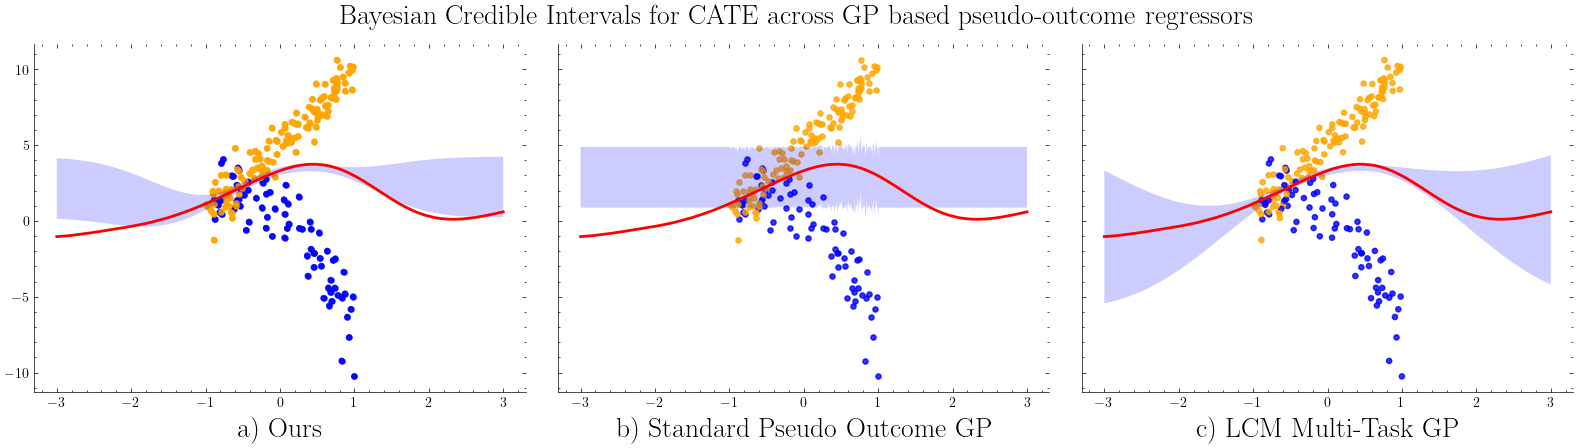

In [105]:
fig

In [106]:
CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

In [107]:
(region_upper - region_lower).mean()

tensor(3.1769, grad_fn=<MeanBackward0>)

In [108]:
def compare_cate_to_guas(CATE,CATE_pred_guas):
    CATE_MSE = torch.mean((CATE - CATE_pred_guas.mean)**2)
    region_lower,region_upper = custom_confidence_region(CATE_pred_guas)
    CATE_coverage = (torch.logical_and((region_lower < Y_true_CATE_GAP),(region_upper > Y_true_CATE_GAP))).float().mean()
    average_interval_width = (region_upper - region_lower).mean()
    return CATE_MSE,CATE_coverage,average_interval_width

In [109]:
handles, labels = axs[0].get_legend_handles_labels()
labels[3],labels[1] = labels[1],labels[3]
handles[1],handles[3] = handles[3],handles[1]
# legend1 = axs[0].legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# reverse the order
legend2 =axs[0].legend(handles, labels,ncols=2,loc="upper left")
# axs[0].legend()

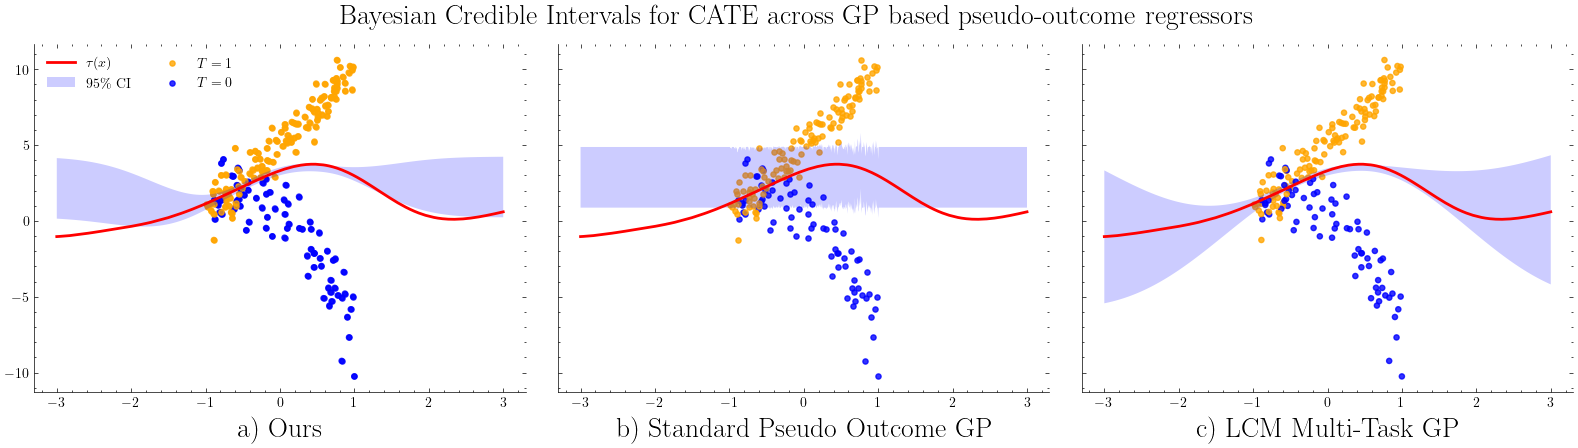

In [110]:
fig

In [111]:
sgadsg

NameError: name 'sgadsg' is not defined

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6532/1416616695.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")


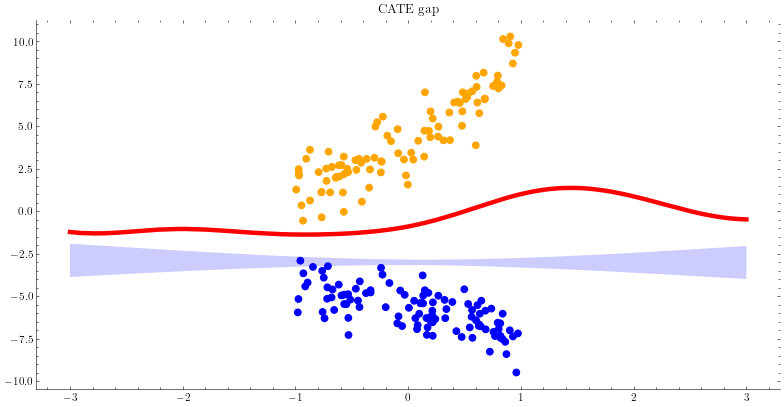

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("CATE gap")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ["blue","orange"]

plt.scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")
plt.fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop,Train=True)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 1.679
Iter 2/50 - Loss: 1.649
Iter 3/50 - Loss: 1.623
Iter 4/50 - Loss: 1.603
Iter 5/50 - Loss: 1.587
Iter 6/50 - Loss: 1.574
Iter 7/50 - Loss: 1.564
Iter 8/50 - Loss: 1.557
Iter 9/50 - Loss: 1.551
Iter 10/50 - Loss: 1.546
Iter 11/50 - Loss: 1.543
Iter 12/50 - Loss: 1.539
Iter 13/50 - Loss: 1.536
Iter 14/50 - Loss: 1.533
Iter 15/50 - Loss: 1.530
Iter 16/50 - Loss: 1.527
Iter 17/50 - Loss: 1.524
Iter 18/50 - Loss: 1.521
Iter 19/50 - Loss: 1.518
Iter 20/50 - Loss: 1.515
Iter 21/50 - Loss: 1.513
Iter 22/50 - Loss: 1.510
Iter 23/50 - Loss: 1.508
Iter 24/50 - Loss: 1.506
Iter 25/50 - Loss: 1.504
Iter 26/50 - Loss: 1.503
Iter 27/50 - Loss: 1.502
Iter 28/50 - Loss: 1.501
Iter 29/50 - Loss: 1.500
Iter 30/50 - Loss: 1.500
Iter 31/50 - Loss: 1.500
Iter 32/50 - Loss: 1.500
Iter 33/50 - Loss: 1.500
Iter 34/50 - Loss: 1.500
Iter 35/50 - Loss: 1.500
Iter 36/50 - Loss: 1.500
Iter 37/50 - Loss: 1.500
Iter 38/50 - Loss: 1.499
Iter 39/50 - Loss: 1.499
Iter 40/50 - Loss: 1.499
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
model.task_covar_module_nuisance.covar_matrix.evaluate()

tensor([[  43.1157, -119.4340,    0.0000],
        [-119.4340,  330.8417,    0.0000],
        [   0.0000,    0.0000,    0.0000]], grad_fn=<AddBackward0>)

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6532/1091842415.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")


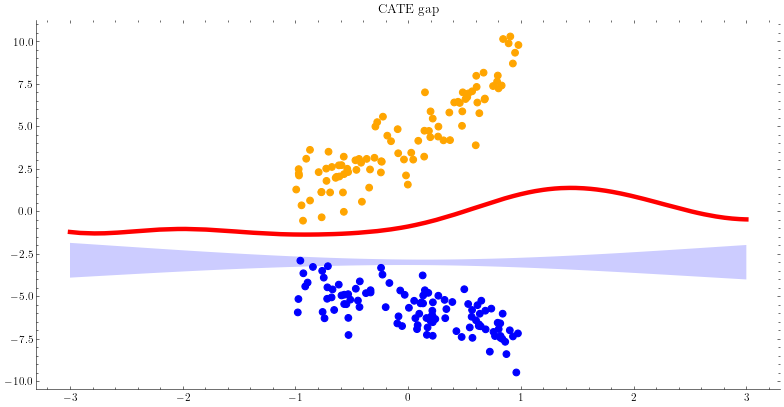

In [ ]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("CATE gap")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ["blue","orange"]

plt.scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")
plt.fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_StandardGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 10.046
Iter 2/50 - Loss: 9.752
Iter 3/50 - Loss: 9.460
Iter 4/50 - Loss: 9.200
Iter 5/50 - Loss: 8.927
Iter 6/50 - Loss: 8.688
Iter 7/50 - Loss: 8.443
Iter 8/50 - Loss: 8.228
Iter 9/50 - Loss: 8.015
Iter 10/50 - Loss: 7.822
Iter 11/50 - Loss: 7.637
Iter 12/50 - Loss: 7.471
Iter 13/50 - Loss: 7.297
Iter 14/50 - Loss: 7.155
Iter 15/50 - Loss: 6.982
Iter 16/50 - Loss: 6.855
Iter 17/50 - Loss: 6.737
Iter 18/50 - Loss: 6.601
Iter 19/50 - Loss: 6.479
Iter 20/50 - Loss: 6.353
Iter 21/50 - Loss: 6.265
Iter 22/50 - Loss: 6.144
Iter 23/50 - Loss: 6.058
Iter 24/50 - Loss: 5.964
Iter 25/50 - Loss: 5.875
Iter 26/50 - Loss: 5.787
Iter 27/50 - Loss: 5.718
Iter 28/50 - Loss: 5.643
Iter 29/50 - Loss: 5.574
Iter 30/50 - Loss: 5.504
Iter 31/50 - Loss: 5.442
Iter 32/50 - Loss: 5.383
Iter 33/50 - Loss: 5.322
Iter 34/50 - Loss: 5.275
Iter 35/50 - Loss: 5.224
Iter 36/50 - Loss: 5.183
Iter 37/50 - Loss: 5.127
Iter 38/50 - Loss: 5.088
Iter 39/50 - Loss: 5.043
Iter 40/50 - Loss: 5.010
Iter 41/

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
X_plot = torch.linspace(-3, 3, 1000)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6532/1416616695.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")


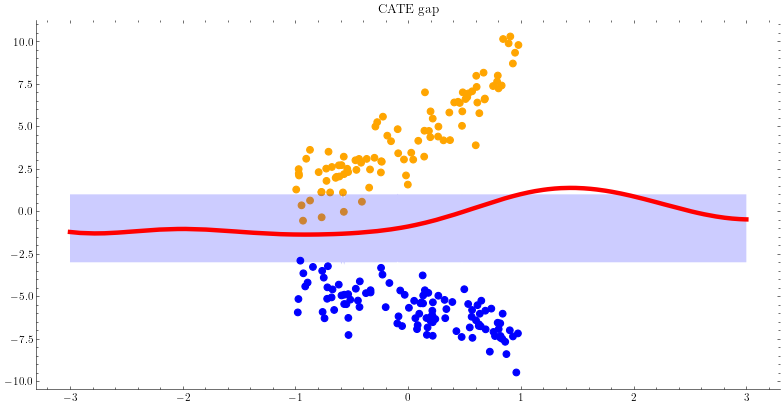

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot()
ax.set_axisbelow(True)
ax.set_title("CATE gap")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
colors = ["blue","orange"]

plt.scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()])

plt.plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=4.0,color="r")
plt.fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

NameError: name 'train_y0' is not defined

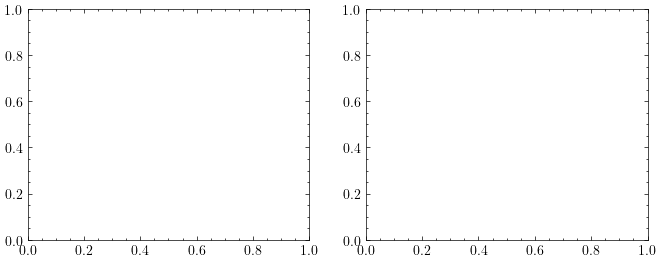

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(-3, 3, 200)
test_i_task0 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y0 = likelihood(model(test_x, test_i_task0))
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y0, train_x0, observed_pred_y0, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')

In [ ]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')

Parameter name: likelihood.noise_covar.raw_noise           value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.raw_lengthscale               value = Parameter containing:
tensor([[0.]], requires_grad=True)


In [ ]:
model(test_x, test_i_task1).mean.detach()

tensor([ 0.0980,  0.1079,  0.1184,  0.1296,  0.1413,  0.1537,  0.1666,  0.1800,
         0.1937,  0.2078,  0.2221,  0.2365,  0.2509,  0.2649,  0.2786,  0.2917,
         0.3039,  0.3150,  0.3248,  0.3329,  0.3390,  0.3429,  0.3442,  0.3426,
         0.3378,  0.3294,  0.3171,  0.3006,  0.2795,  0.2538,  0.2231,  0.1871,
         0.1459,  0.0993,  0.0473, -0.0101, -0.0728, -0.1404, -0.2128, -0.2896,
        -0.3702, -0.4541, -0.5405, -0.6288, -0.7180, -0.8071, -0.8951, -0.9808,
        -1.0631, -1.1407, -1.2123, -1.2765, -1.3321, -1.3777, -1.4120, -1.4337,
        -1.4418, -1.4351, -1.4127, -1.3737, -1.3176, -1.2437, -1.1519, -1.0421,
        -0.9144, -0.7691, -0.6070, -0.4288, -0.2357, -0.0289,  0.1898,  0.4189,
         0.6562,  0.8997,  1.1470,  1.3958,  1.6435,  1.8875,  2.1253,  2.3542,
         2.5719,  2.7757,  2.9633,  3.1328,  3.2820,  3.4093,  3.5132,  3.5925,
         3.6463,  3.6742,  3.6757,  3.6511,  3.6008,  3.5256,  3.4266,  3.3050,
         3.1627,  3.0017,  2.8239,  2.63

In [ ]:
model.CATE(test_x)

MultivariateNormal(loc: torch.Size([200]))

In [ ]:
model(test_x, test_i_task1).mean.detach() - model(test_x, test_i_task0).mean.detach()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
with gpytorch.settings.fast_pred_var():
    out = model((torch.cat[X1, X2], dim=-2))
    cross_covar = out.lazy_covariance_matrix[:n, n:]

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2574102101.py, line 2)

In [ ]:
model(torch.concat([test_x[:1],test_x[:1]]), torch.concat([test_i_task0[:1],test_i_task1[:1]])).ker.detach()


tensor([[0.4443, 0.2579],
        [0.2579, 0.3987]])

In [ ]:
gpytorch.kernels.LCMKernel()


In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)
    
    def CATE(self,x):

        n = x.shape[0]

        zeros_like_x = torch.full((x.shape[0],1), dtype=torch.long, fill_value=0)
        ones_like_x = torch.full((x.shape[0],1), dtype=torch.long, fill_value=1)

        out = self(torch.cat([x, x]),torch.cat([ones_like_x, zeros_like_x]))
        
        mean = out.mean.detach()[:n] - out.mean.detach()[n:]
        
        covar = out.lazy_covariance_matrix
        stdv = covar[:n,:n].diag()+covar[n:,n:].diag() - 2*covar[n:,:n].diag() 
        return mean, stdv 

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x0.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x0, train_x1])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y0, train_y1])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [ ]:
task_ker = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

In [ ]:
task_ker.covar_factor

Parameter containing:
tensor([[ 0.6258],
        [-1.1067]], requires_grad=True)

In [ ]:
p_score = 0.5

In [ ]:
mu = torch.tensor([[(1/p_score)**2, (1/p_score*(1-p_score))], [(1/p_score*(1-p_score)),(1/(1-p_score))**2]])

tensor([[4., 1.],
        [1., 4.]])

In [ ]:
gpytorch.priors.MultivariateNormalPrior(loc = torch.tensor(mu),covariance_matrix = torch.eye(2))

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_5455/1691316397.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpytorch.priors.MultivariateNormalPrior(loc = torch.tensor(mu),covariance_matrix = torch.eye(2))


MultivariateNormalPrior(covariance_matrix: torch.Size([2, 2, 2]))

In [ ]:
kern.covar_factor.shape

torch.Size([2, 1])

In [ ]:
kern.raw_var

Parameter containing:
tensor([-inf, -inf], requires_grad=True)

In [ ]:
M = kern.covar_matrix

In [ ]:
M.evaluate()

tensor([[ 4., -4.],
        [-4.,  4.]], grad_fn=<AddBackward0>)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x0.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x0, train_x1])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y0, train_y1])

# Here we have two iterms that we're passing in as train_inputs
model =PseudoOutcome_MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [ ]:
model.task_covar_module_nuisance.covar_factor, model.task_covar_module_nuisance.var

(Parameter containing:
 tensor([[ 2.],
         [-2.],
         [ 0.]]),
 tensor([0., 0., 0.], grad_fn=<SoftplusBackward0>))

In [ ]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()
model.eval()
likelihood.eval()

Iter 1/50 - Loss: 3.572
Iter 2/50 - Loss: 3.417
Iter 3/50 - Loss: 3.279
Iter 4/50 - Loss: 3.156
Iter 5/50 - Loss: 3.046
Iter 6/50 - Loss: 2.949
Iter 7/50 - Loss: 2.864
Iter 8/50 - Loss: 2.788
Iter 9/50 - Loss: 2.721
Iter 10/50 - Loss: 2.662
Iter 11/50 - Loss: 2.609
Iter 12/50 - Loss: 2.563
Iter 13/50 - Loss: 2.522
Iter 14/50 - Loss: 2.486
Iter 15/50 - Loss: 2.454
Iter 16/50 - Loss: 2.426
Iter 17/50 - Loss: 2.401
Iter 18/50 - Loss: 2.378
Iter 19/50 - Loss: 2.359
Iter 20/50 - Loss: 2.341
Iter 21/50 - Loss: 2.325
Iter 22/50 - Loss: 2.311
Iter 23/50 - Loss: 2.298
Iter 24/50 - Loss: 2.286
Iter 25/50 - Loss: 2.276
Iter 26/50 - Loss: 2.267
Iter 27/50 - Loss: 2.258
Iter 28/50 - Loss: 2.250
Iter 29/50 - Loss: 2.243
Iter 30/50 - Loss: 2.237
Iter 31/50 - Loss: 2.231
Iter 32/50 - Loss: 2.226
Iter 33/50 - Loss: 2.221
Iter 34/50 - Loss: 2.216
Iter 35/50 - Loss: 2.212
Iter 36/50 - Loss: 2.209
Iter 37/50 - Loss: 2.205
Iter 38/50 - Loss: 2.202
Iter 39/50 - Loss: 2.199
Iter 40/50 - Loss: 2.196
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
model(full_train_x, full_train_i).mean

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor([ 3.4732,  3.5023,  1.7797,  3.4835,  3.0722,  2.5036,  3.0922,  2.3913,
         3.0264,  2.9025,  2.5657,  2.2562,  3.2429,  3.1671,  2.9552,  2.3651,
         1.7419,  3.4424,  1.6740,  1.9286,  3.2639,  3.4764,  3.4778,  3.0930,
         2.8373,  2.4627,  1.9561,  1.7457,  3.4147,  1.9801,  3.2410,  3.5140,
         2.0256,  3.4380,  3.1556,  3.0476,  2.0301,  3.5151,  2.5697,  2.0432,
         3.5053,  3.2213,  1.7825,  2.0044,  1.9264,  2.5751,  2.6869,  3.3938,
         3.4624,  3.4832,  3.5114,  3.4321,  3.3674,  3.4041,  3.0542,  3.3160,
         3.1116,  3.2676,  3.4294,  3.2506,  2.3525,  3.2955,  1.9397,  3.4969,
         1.6862,  2.1831,  2.9524,  2.3774,  3.2049,  2.2573,  3.2665,  1.9040,
         3.2454,  3.4685,  3.5127,  3.2044,  3.3293,  2.5413,  3.4130,  1.8374,
         2.3302,  3.2435,  2.4712,  3.4830,  3.2564,  3.2855,  2.6894,  3.2436,
         2.3662,  1.7849,  2.8715,  2.6033,  3.3487,  1.7822,  3.4745,  3.5118,
         2.4608,  1.7634,  3.4484,  3.50

In [ ]:
model(full_train_x, 2*torch.ones_like(full_train_i)).mean

tensor([0.8327, 0.9806, 1.0163, 1.0175, 0.7934, 0.8761, 0.7918, 0.8972, 0.7975,
        0.8117, 0.8649, 0.9235, 1.2781, 1.3396, 0.8052, 0.9022, 1.0226, 1.0776,
        1.0303, 0.9885, 1.2601, 0.8350, 0.8360, 1.3954, 0.8206, 0.8837, 0.9831,
        1.0220, 1.1114, 0.9784, 0.7863, 0.9463, 0.9694, 0.8146, 0.7880, 1.4278,
        0.9685, 0.9414, 0.8641, 0.9659, 0.8653, 0.7862, 1.0159, 0.9736, 0.9889,
        0.8632, 0.8440, 1.1349, 1.0503, 1.0179, 0.9559, 1.0905, 1.1629, 0.8037,
        0.7949, 1.2131, 1.3818, 1.2569, 0.8114, 0.7864, 0.9047, 0.7881, 0.9863,
        0.9924, 1.0298, 0.9380, 0.8055, 0.8999, 0.7864, 0.9232, 0.7868, 0.9933,
        0.7863, 1.0413, 0.8809, 1.3100, 0.7909, 0.8692, 0.8061, 1.0059, 0.9090,
        1.2775, 0.8821, 1.0183, 1.2665, 0.7876, 0.8436, 1.2774, 0.9020, 1.0154,
        0.8159, 0.8582, 0.7932, 1.0159, 0.8336, 0.8784, 0.8840, 1.0191, 1.0696,
        0.8724, 0.7871, 0.8862, 1.0214, 0.8068, 1.1617, 0.7949, 0.9021, 0.9656,
        1.3466, 0.9985, 1.2890, 1.2220, 

In [ ]:
x = full_train_x
i = full_train_i

In [ ]:
model.eval()
mean_x = model.mean_module(x)

# Get input-input covariance
covar_x_CATE = model.covar_module_CATE(x)

covar_x_nuisance = model.covar_module_CATE(x)
# Get task-task covariance
covar_i_nuisance = model.task_covar_module_nuisance(i)
# Multiply the two together to get the covariance we want
covar_nuisance = covar_x_nuisance.mul(covar_i_nuisance)

covar = covar_x_CATE + covar_nuisance
gpytorch.distributions.MultivariateNormal(mean_x, covar).mean

tensor([1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610, 1.1610,
        1.1610, 1.1610, 1.1610, 1.1610, 